In [ ]:
# hide
from nbdev.showdoc import show_doc

# Glass Identification
> In this example, we will use a standard imbalanced machine learning dataset referred to as the “Glass Identification” dataset.

The dataset describes the chemical properties of glass and involves classifying samples of glass using their chemical properties as one of seven classes. There are nine input variables that summarize the properties
- **RI:** refractive index
- **Na:** Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
- **Mg:** Magnesium
- **Al:** Aluminum
- **Si:** Silicon
- **K:** Potassium
- **Ca:** Calcium
- **Ba:** Barium
- **Fe:** Iron

The chemical compositions are measured as the weight percent in corresponding oxide. There are seven types of glass listed (class attribute)
- **1:** building_windows_float_processed
- **2:** building_windows_non_float_processed
- **3:** vehicle_windows_float_processed
- **4:** vehicle_windows_non_float_processed (none in this database)
- **5:** containers
- **6:** tableware
- **7:** headlamps

## Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation, MyDropout
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD


In [ ]:
def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)

def angle2class(x: torch.tensor, categories:int, periodicity:int) -> torch.tensor:
    tmp = x.angle() + 2 * np.pi
    angle = torch.remainder(tmp, 2 * np.pi)

    # This will be the discrete output (the number of sector)
    o = torch.floor(categories * periodicity * angle / (2 * np.pi))
    return torch.remainder(o, categories)

## Load Glass Identification Data Set

In [ ]:
use_local_data = False

if use_local_data:
    column_names = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe"]
    X_df = pd.read_csv(
        "/media/anton/Daten/Dev/Python/CVNNMVN/examples/glass classification/glass_setX.csv",
        names=column_names,
    )
    # X_df = pd.read_csv('/Users/anton/Documents/Dev/Python/CVNNMVN/examples/glass classification/glass_setX.csv', names=column_names)
    column_names = ["Type of glass"]
    y_df = pd.read_csv(
        "/media/anton/Daten/Dev/Python/CVNNMVN/examples/glass classification/glass_setY.csv",
        names=column_names,
    )
    # y_df = pd.read_csv('/Users/anton/Documents/Dev/Python/CVNNMVN/examples/glass classification/glass_setY.csv', names=column_names)
    X, y = X_df.to_numpy(), y_df.to_numpy()
else:
    column_names = [
        "ID",
        "RI",
        "Na",
        "Mg",
        "Al",
        "Si",
        "K",
        "Ca",
        "Ba",
        "Fe",
        "Type of glass",
    ]
    df = pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data",
        names=column_names,
    )
    df.drop(["ID"], axis=1, inplace=True)

    data = df.to_numpy()
    X, y = data[:, :-1], data[:, -1]
    y = y - 1
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)

X, y = shuffle(X, y, random_state=0)

## Prepare data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# linear scaling of real-valued inputs to complex-valued inputs (on unit circle)
def transform(data, alpha=2 * np.pi):
    for feature in range(data.shape[1]):
        a = np.min(data[:, feature])
        b = np.max(data[:, feature])
        data[:, feature] = ((data[:, feature] - a) / (b - a)) * alpha
        # ((1.52101 - a) / ( b - a )) * ((2 * np.pi) - (np.pi /8)  ) ????
    # data = np.round(data, 3)
    # return np.exp(1.j * np.remainder(data, 2*np.pi))
    return np.exp(1.0j * data)


def transform_unitCircle(data):
    return np.exp(1.0j * np.remainder(data, 2 * np.pi))


if use_local_data:
    X_scaled = transform(X, alpha=2 * np.pi - np.pi / 8)
else:
    X_scaled = transform_unitCircle(X)

In [ ]:
# one-hot-encoding for MVN
numSamples, numFeatures = X.shape
y2 = y + 1  # auxiliary variable so that classes start at 1 and not 0
neuronCats = 6  # parameter that determines the number of output neurons
no = int(np.ceil(max(y2) / neuronCats))  # number of output neurons
if no != 1:
    y = torch.zeros(numSamples, no)
    for i in range(numSamples):
        k = int(np.ceil(y2[i] / neuronCats)) - 1
        c = np.mod((y2[i] - 1), neuronCats) + 1
        y[i, k] = c

### EDA

#### Feature Distributions

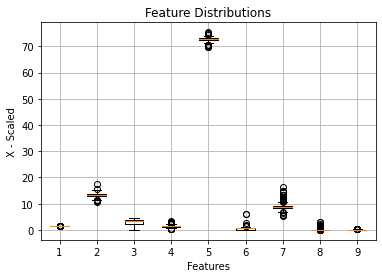

In [ ]:
#| echo: false
# X_df.boxplot()
plt.boxplot(X)
plt.xlabel("Features")
plt.ylabel("X - Scaled")
plt.title("Feature Distributions")
plt.grid()
plt.show()

#### Class Distributions

In [ ]:
#| echo: false
from collections import Counter

# target = y_df.values[:, -1]

counter = Counter(y)
for k, v in counter.items():
    per = v / len(y) * 100
    print("Class =%2d, Count =%3d, Percentage = %.3f%%" % (k, v, per))

Class = 5, Count = 29, Percentage = 13.551%
Class = 0, Count = 70, Percentage = 32.710%
Class = 1, Count = 76, Percentage = 35.514%
Class = 4, Count =  9, Percentage = 4.206%
Class = 3, Count = 13, Percentage = 6.075%
Class = 2, Count = 17, Percentage = 7.944%


### Histograms of all variables

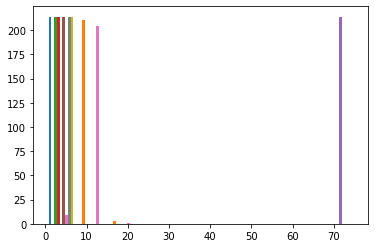

In [ ]:
#| echo: false
# X_df.hist(figsize=[14, 8])
plt.hist(X)
plt.show()

## Stratified k-Fold Cross-Validation

### Models

#### MLMVN

In [ ]:
#| hide
ns, ni = X.shape

# Training loop
epochs = 1000  # how many epochs to train for
bs = 300  # batch size
loss_vals = []
acc_vals = []

scores_train = []
scores_test = []
classif_ratesum = 0

loo = LeaveOneOut()
loo.get_n_splits(X)

# log_param("epochs", epo
# chs)
# log_param("batch size", bs)

214

In [ ]:
class MLMVN(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_linear = FirstLayer(ni, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_linear = HiddenLayer(20, 10)
        self.phase_act2 = cmplx_phase_activation()
        self.output_linear = OutputLayer(10, no)
        # self.dropout = MyDropout(0.25)
        self.phase_act3 = cmplx_phase_activation()

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_linear(x)
        x = self.phase_act2(x)
        x = self.output_linear(x)
        # x = self.dropout(x)
        x = self.phase_act3(x)
        return x
    
    def predict(self, x, loss):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return output

# Implement the train function given a training dataset X and correcsponding labels y
def train(
    model,
    X,
    y,
    epochs,
    batch_size,
    optimizer,
    criterion,
    categories,
    periodicity
):
    # List of losses for visualization
    losses = []
    scores = []

    list_weights = []
    list_bias = []
    list_outputs = []
    list_self_adjusting_learning_rate = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]


            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(xb)

            loss = criterion(y_pred, yb, categories, periodicity)
            # wandb.log({"loss": torch.abs(loss)})
            
            if i % 10 == 9: print(torch.abs(loss))
            batch_loss.append((torch.abs(loss)).detach().numpy())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(sum(batch_loss)/len(batch_loss))
        y_pred = model(X)
        y_pred = angle2class(y_pred, categories, periodicity)
        scores.append(accuracy(y_pred.squeeze(), y))

    return (
        losses,
        scores,
        list_weights,
        list_bias,
        list_outputs,
        list_self_adjusting_learning_rate,
    )

In [ ]:
#| hide
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

scores_train = []
scores_test = []

for train_index, test_index in rskf.split(X_scaled, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert numpy arrays into torch tensors
    X_train_t, y_train_t, X_test_t, y_test_t = map(
        torch.tensor, (X_train, y_train, X_test, y_test)
    )

    # MVN
    model = MLMVN()
    criterion = ComplexMSELoss.apply
    # optimizer = torch.optim.SGD(model.parameters(), lr=1)
    optimizer = MySGD(model.parameters(), lr=1)
    categories =  6
    periodicity = 1

    (
        losses,
        scores,
        list_weights,
        list_bias,
        list_outputs,
        list_self_adjusting_learning_rate,
    ) = train(model, X_train_t, y_train_t, epochs=200, batch_size=300, optimizer=optimizer, criterion=criterion, categories=categories, periodicity=periodicity)

    y_pred = model(X_train_t)
    y_pred = angle2class(y_pred, categories, periodicity)
    acc = accuracy(y_pred.squeeze(), y_train_t)
    scores_train.append(acc)
    print("Train Accuracy: ", acc)

    y_pred = model(X_test_t)
    y_pred = angle2class(y_pred, categories, periodicity)
    acc = accuracy(y_pred.squeeze(), y_test_t)
    scores_test.append(acc)
    print("Test Accuracy: ", acc)

# log_metric(key="Mean Train Accuracy", value=np.mean(scores_train))
# log_metric(key="Mean Test Accuracy", value=np.mean(scores_test))

tensor(1.4153, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4427, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.7631, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.9355, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.9475, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6602, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6251, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4629, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6221, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3944, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3725, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2825, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.5847, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6746, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.0198, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.5391, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6916, dtype=torch.float64, grad

In [ ]:
#| echo: false
print("Train: %.3f (%.3f)" % (np.mean(scores_train), np.std(scores_train)))
print("Test: %.3f (%.3f)" % (np.mean(scores_test), np.std(scores_test)))

Train: 0.642 (0.140)
Test: 0.444 (0.102)



### Support Vector Machine (SVM), k-Nearest Neighbors (KNN), Bagged Decision Trees (BAG), Random Forest (RF), Extra Trees (ET)

In [ ]:
#| echo: false
# spot check machine learning algorithms on the glass identification dataset
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

# evaluate a model
def evaluate_model(X, y, model, cv):
    # evaluate model
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    return scores


# define models to test
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma="auto"))
    names.append("SVM")
    # KNN
    models.append(KNeighborsClassifier())
    names.append("KNN")
    # # Bagging
    # models.append(BaggingClassifier(n_estimators=1000))
    # names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append("RF")
    # # ET
    # models.append(ExtraTreesClassifier(n_estimators=1000))
    # names.append('ET')
    return models, names


# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y.ravel(), models[i], rskf)
    results.append(scores)
    # summarize performance
    print(">%s %.3f (%.3f)" % (names[i], mean(scores), std(scores)))

>SVM 0.662 (0.055)
>KNN 0.662 (0.080)
>RF 0.788 (0.059)


In [ ]:
#| hide
# Add mlmvn results
names.append("MLMVN")
results.append(scores_test)

### Results

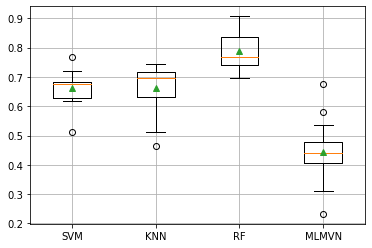

In [ ]:
#| echo: false
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.grid()
pyplot.show()